# Ensemble classification model in earthquake building damage level detection

# Importing Libraries

In [ ]:
!pip install xgboost
!pip install catboost
!pip install imbalanced-ensemble
!pip install sdv

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 1.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 268 kB 17.3 MB/s 
     |████████████████████████████████| 9.4 MB 58.2 MB/s 
     |████████████████████████████████| 965 kB 64.9 MB/s 
     |████████████████████████████████| 295 kB 64.5 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.2.2
    Uninstalling matplotlib-3.2.2:
      Successfully uninstalled matplotlib-3.2.2


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 102 kB 269 kB/s 
     |████████████████████████████████| 53 kB 2.2 MB/s 
     |████████████████████████████████| 47 kB 5.3 MB/s 
     |████████████████████████████████| 1.6 MB 109.9 MB/s 
     |████████████████████████████████| 61 kB 391 kB/s 
     |████████████████████████████████| 139 kB 87.3 MB/s 
     |████████████████████████████████| 280 kB 90.9 MB/s 
     |████████████████████████████████| 662 kB 104.6 MB/s 
     |████████████████████████████████| 15.3 MB 89.5 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
  Attempting uninstall: psutil
    Found existing installation: psutil 5.4.8
    Uninstalling psutil-5.4.8:
      Successfully uninstalled psutil-5.4.8
  Attempting uninstall: plotly
    Found existing installation: plotly 5.5.0
    Unin

In [ ]:
import numpy as np
import pandas as pd
import cv2
from sdv import SDV

from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding

from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import RidgeClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from imblearn.over_sampling import SMOTE
from google.colab import drive

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb

# Data Loading

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_values.csv", index_col='building_id')

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
building_id,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
28830,8,900,2812,2,10,8,7,o,r,n,...,0,0,0,0,0,0,0,0,0,0
94947,21,363,8973,2,10,5,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
590882,22,418,10694,2,10,6,5,t,r,n,...,0,0,0,0,0,0,0,0,0,0
201944,11,131,1488,3,30,8,9,t,r,n,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
Y= pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/train_labels.csv", index_col='building_id')

In [ ]:
Y.head()

,damage_grade
building_id,
802906,3
28830,2
94947,3
590882,2
201944,3


In [ ]:
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/test_values.csv", index_col='building_id')

In [ ]:
X.describe()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
count,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,...,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000,260601.000000
mean,13.900353,701.074685,6257.876148,2.129723,26.535029,8.018051,5.434365,0.088645,0.761935,0.034332,...,0.064378,0.033626,0.008101,0.000940,0.000361,0.001071,0.000188,0.000146,0.000088,0.005119
std,8.033617,412.710734,3646.369645,0.727665,73.565937,4.392231,1.918418,0.284231,0.425900,0.182081,...,0.245426,0.180265,0.089638,0.030647,0.018989,0.032703,0.013711,0.012075,0.009394,0.071364
min,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000000,350.000000,3073.000000,2.000000,10.000000,5.000000,4.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,12.000000,702.000000,6270.000000,2.000000,15.000000,7.000000,5.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,21.000000,1050.000000,9412.000000,2.000000,30.000000,9.000000,6.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30.000000,1427.000000,12567.000000,9.000000,995.000000,100.000000,32.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Feature Engineering : Conditional Probabilities of geo_levels

#### ID-1

In [ ]:
fea = pd.merge(X, Y, on='building_id')

In [ ]:
#this block of code calculates the probabilities
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in (X['geo_level_1_id'].value_counts()).iteritems():
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-11-193d97af5c95>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_1_id']==i])
<ipython-input-11-193d97af5c95>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_1_id']==i])
<ipython-input-11-193d97af5c95>:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_1_id']==i])


In [ ]:
# this block of code appends a new column/feature of probabilities
list1 = []
list2 = []
list3 = []

for i in X['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo1'] = list1
X['prob2_geo1'] = list2
X['prob3_geo1'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_1_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo1'] = list1
test['prob2_geo1'] = list2
test['prob3_geo1'] = list3

#### ID-2

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_2_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-14-9600c538556e>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_2_id']==i])
<ipython-input-14-9600c538556e>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_2_id']==i])
<ipython-input-14-9600c538556e>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_2_id']==i])


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo2'] = list1
X['prob2_geo2'] = list2
X['prob3_geo2'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_2_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo2'] = list1
test['prob2_geo2'] = list2
test['prob3_geo2'] = list3

#### ID-3

In [ ]:
damage1 = {}
damage2 = {}
damage3 = {}

for i,j in ((X['geo_level_3_id'].value_counts()).iteritems()):
    
    n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
    n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
    n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])

    damage1[i] = n1/j
    damage2[i] = n2/j
    damage3[i] = n3/j

<ipython-input-17-a91eef80d342>:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n1 = len(fea[fea['damage_grade']==1][fea['geo_level_3_id']==i])
<ipython-input-17-a91eef80d342>:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n2 = len(fea[fea['damage_grade']==2][fea['geo_level_3_id']==i])
<ipython-input-17-a91eef80d342>:9: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  n3 = len(fea[fea['damage_grade']==3][fea['geo_level_3_id']==i])


In [ ]:
list1 = []
list2 = []
list3 = []

for i in X['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

X['prob1_geo3'] = list1
X['prob2_geo3'] = list2
X['prob3_geo3'] = list3

In [ ]:
list1 = []
list2 = []
list3 = []

for i in test['geo_level_3_id']:
    list1.append(damage1.get(i))
    list2.append(damage2.get(i))
    list3.append(damage3.get(i))

test['prob1_geo3'] = list1
test['prob2_geo3'] = list2
test['prob3_geo3'] = list3

# Feature Engineering: Finding relation between geo_levels using seq_to_seq method (LSTM)

<font size=2> **Below is just an example to show how the geo_levels might be related in some way to each other.**
**For geo_level_1 = 6 and geo_level_2=487 we see there are a lot of same geo_levels-3 indicating that there is some relation between these levels.**</font>

In [ ]:
pd.DataFrame(X['geo_level_3_id'][X['geo_level_2_id']==487][X['geo_level_1_id']==6]).head(50)

,geo_level_3_id
building_id,
802906,12198
959468,12198
410679,7439
423950,7439
215003,12198
594969,835
695349,2908
869506,7439
141511,382


### Converting the geo_levels 1 and 2 into one hot encoder with shared vocabulary

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']])
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']])
l3 = pd.concat([X['geo_level_3_id'], test['geo_level_3_id']])

In [ ]:
#get shared vocab of l1 and l2
inp = pd.concat([l1,l2]).to_numpy().reshape(-1,1)

In [ ]:
l1 = pd.concat([X['geo_level_1_id'], test['geo_level_1_id']]).to_numpy().reshape(-1,1)

In [ ]:
l2 = pd.concat([X['geo_level_2_id'], test['geo_level_2_id']]).to_numpy().reshape(-1,1)

In [ ]:
onehot = OneHotEncoder(sparse=False)

In [ ]:
onehot.fit(inp)

OneHotEncoder(sparse=False)

In [ ]:
inp.shape

(694938, 1)

In [ ]:
onehot.categories_

[array([   0,    1,    2, ..., 1425, 1426, 1427])]

In [ ]:
l1_hot = onehot.transform(l1)

In [ ]:
l1_hot.shape

(347469, 1419)

In [ ]:
l2_hot = onehot.transform(l2)

In [ ]:
l2_hot.shape

(347469, 1419)

In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(347469, 2, 1419)

### Converting geo_level_3 into onehot

In [ ]:
l3_hot = np.array(pd.get_dummies(l3))

In [ ]:
l3_hot.shape

(347469, 11861)

### Creating a LSTM model to get relation features.

In [ ]:
inpx = Input( shape=fin_inp.shape[1:] )  

lstm = LSTM(16, )(inpx)

lvl3 = Dense(l3_hot.shape[1], activation='sigmoid')(lstm)

modelf = Model(inputs= inpx, outputs=lvl3)

modelf.compile(loss='binary_crossentropy', optimizer='adam')

modelf.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2, 1419)]         0         
                                                                 
 lstm (LSTM)                 (None, 16)                91904     
                                                                 
 dense (Dense)               (None, 11861)             201637    
                                                                 
Total params: 293,541
Trainable params: 293,541
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modelf.fit(fin_inp, l3_hot, epochs=30, batch_size=128)

Epoch 1/30
2715/2715 [==============================] - 18s 4ms/step - loss: 0.0396
Epoch 2/30
2715/2715 [==============================] - 12s 4ms/step - loss: 9.7066e-04
Epoch 3/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.4847e-04
Epoch 4/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.3365e-04
Epoch 5/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.3094e-04
Epoch 6/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.3016e-04
Epoch 7/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2986e-04
Epoch 8/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2971e-04
Epoch 9/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2963e-04
Epoch 10/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2958e-04
Epoch 11/30
2715/2715 [==============================] - 12s 4ms/step - loss: 8.2952e-04
Epoch 12/30
2715/2715 [===========

### Getting the relation vector from the output of intermediate layer

In [ ]:
inter = Model(inputs=modelf.input, outputs=modelf.layers[1].output)

<font size=3>**Train**</font>

In [ ]:
l1 = X['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = X['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(260601, 2, 1419)

In [ ]:
geo_fea_train = inter.predict(fin_inp)

8144/8144 [==============================] - 12s 1ms/step


<font size=3>**Test**</font>

In [ ]:
l1 = test['geo_level_1_id'].to_numpy().reshape(-1,1)

l2 = test['geo_level_2_id'].to_numpy().reshape(-1,1)

In [ ]:
l1_hot = onehot.transform(l1)
l2_hot = onehot.transform(l2)


In [ ]:
fin_inp = np.stack((l1_hot,l2_hot), axis=1)
fin_inp.shape

(86868, 2, 1419)

In [ ]:
geo_fea_test = inter.predict(fin_inp)

2715/2715 [==============================] - 4s 1ms/step


# Final  Data

In [ ]:
print("train {}, test {}  ".format(geo_fea_train.shape, geo_fea_test.shape))

train (260601, 16), test (86868, 16)  


### Preprocessing the data with pd.get_dummies and adding the relation features

In [ ]:
fx_tr = np.hstack((np.array(pd.get_dummies(X.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))),
                   geo_fea_train))

In [ ]:
fx_tr

array([[ 2.        , 30.        ,  6.        , ..., -0.96252465,
        -0.96321988, -0.96322203],
       [ 2.        , 10.        ,  8.        , ...,  0.9632104 ,
        -0.96331304, -0.96334994],
       [ 2.        , 10.        ,  5.        , ..., -0.96280354,
        -0.96324784, -0.96322203],
       ...,
       [ 3.        , 55.        ,  6.        , ..., -0.96076262,
        -0.96317488, -0.96326113],
       [ 2.        , 10.        , 14.        , ..., -0.96307248,
        -0.96369028, -0.96371078],
       [ 3.        , 10.        ,  7.        , ..., -0.96283561,
        -0.9632479 , -0.96322274]])

In [ ]:
fx_tr.shape

(260601, 90)

In [ ]:
test.fillna(value=0, inplace=True)

In [ ]:
fx_te = np.hstack((np.array(pd.get_dummies(test.copy().drop(['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id'], axis=1))), geo_fea_test))

fx_te.shape

(86868, 90)

In [ ]:
fy_tr = Y.to_numpy().ravel()
fy_tr.shape

(260601,)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(fx_tr, fy_tr, test_size=0.2, random_state=42)

# Generated Data

In [ ]:
data_real = pd.DataFrame(fx_tr)
data_real = data_real.add_prefix('column_')

In [ ]:
data_real.shape

(260601, 91)

In [ ]:
data_real["damage"] = fy_tr

In [ ]:
data_real.head()

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,damage
0,2.0,30.0,6.0,5.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.963271,0.297992,0.962617,0.014763,0.962447,0.963190,-0.962525,-0.963220,-0.963222,3
1,2.0,10.0,8.0,7.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.962965,0.961767,0.962611,0.748483,0.961827,0.963336,0.963210,-0.963313,-0.963350,2
2,2.0,10.0,5.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.963196,0.887105,0.962090,0.959400,0.961677,0.963197,-0.962804,-0.963248,-0.963222,3
3,2.0,10.0,6.0,5.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.962930,0.959049,0.959997,0.955476,-0.783976,0.963156,-0.956366,-0.963040,-0.962925,2
4,3.0,30.0,8.0,9.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.962779,0.913627,0.961408,0.451547,0.957830,0.963061,-0.960661,-0.962695,-0.962876,3


In [ ]:
from sdv.demo import load_tabular_demo
data = load_tabular_demo('student_placements')
data

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17264,M,67.00,91.00,Commerce,58.00,Sci&Tech,False,0,55.0,Mkt&HR,58.80,27000.0,True,2020-07-23,2020-10-12,3.0
1,17265,M,79.33,78.33,Science,77.48,Sci&Tech,True,1,86.5,Mkt&Fin,66.28,20000.0,True,2020-01-11,2020-04-09,3.0
2,17266,M,65.00,68.00,Arts,64.00,Comm&Mgmt,False,0,75.0,Mkt&Fin,57.80,25000.0,True,2020-01-26,2020-07-13,6.0
3,17267,M,56.00,52.00,Science,52.00,Sci&Tech,False,0,66.0,Mkt&HR,59.43,NaN,False,NaT,NaT,NaN
4,17268,M,85.80,73.60,Commerce,73.30,Comm&Mgmt,False,0,96.8,Mkt&Fin,55.50,42500.0,True,2020-07-04,2020-09-27,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210,17474,M,80.60,82.00,Commerce,77.60,Comm&Mgmt,False,0,91.0,Mkt&Fin,74.49,40000.0,True,2020-07-27,2020-10-20,3.0
211,17475,M,58.00,60.00,Science,72.00,Sci&Tech,False,0,74.0,Mkt&Fin,53.62,27500.0,True,2020-01-23,2020-08-04,6.0
212,17476,M,67.00,67.00,Commerce,73.00,Comm&Mgmt,True,1,59.0,Mkt&Fin,69.72,29500.0,True,2020-01-25,2020-08-05,6.0
213,17477,F,74.00,66.00,Commerce,58.00,Comm&Mgmt,False,0,70.0,Mkt&HR,60.23,20400.0,True,2020-01-19,2020-04-20,3.0


In [ ]:
from sdv.tabular import CTGAN
model = CTGAN(verbose=True)
model.fit(data)

Epoch 1, Loss G:  0.8252,Loss D: -0.0134


/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[column_name] = data[column_name].to_numpy().flatten()
/usr/local/lib/python3.8/dist-packages/ctgan/data_transformer.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


Epoch 2, Loss G:  0.8506,Loss D: -0.0190
Epoch 3, Loss G:  0.8461,Loss D: -0.0304
Epoch 4, Loss G:  0.8610,Loss D: -0.0753
Epoch 5, Loss G:  0.8614,Loss D: -0.0683
Epoch 6, Loss G:  0.8558,Loss D: -0.0551
Epoch 7, Loss G:  0.8071,Loss D: -0.0663
Epoch 8, Loss G:  0.8570,Loss D: -0.1172
Epoch 9, Loss G:  0.8348,Loss D: -0.1409
Epoch 10, Loss G:  0.7724,Loss D: -0.1473
Epoch 11, Loss G:  0.7848,Loss D: -0.1526
Epoch 12, Loss G:  0.7346,Loss D: -0.1770
Epoch 13, Loss G:  0.7326,Loss D: -0.1386
Epoch 14, Loss G:  0.6351,Loss D: -0.1882
Epoch 15, Loss G:  0.6651,Loss D: -0.1963
Epoch 16, Loss G:  0.5900,Loss D: -0.2057
Epoch 17, Loss G:  0.4743,Loss D: -0.1765
Epoch 18, Loss G:  0.4416,Loss D: -0.2155
Epoch 19, Loss G:  0.4067,Loss D: -0.1112
Epoch 20, Loss G:  0.2194,Loss D: -0.1028
Epoch 21, Loss G:  0.2375,Loss D: -0.1591
Epoch 22, Loss G:  0.1735,Loss D: -0.1614
Epoch 23, Loss G:  0.0927,Loss D: -0.0333
Epoch 24, Loss G: -0.0173,Loss D:  0.0222
Epoch 25, Loss G: -0.0670,Loss D: -0.0532


In [ ]:
new_data = model.sample(num_rows=20000)
new_data

,student_id,gender,second_perc,high_perc,high_spec,degree_perc,degree_type,work_experience,experience_years,employability_perc,mba_spec,mba_perc,salary,placed,start_date,end_date,duration
0,17336,F,54.94,79.93,Science,87.39,Sci&Tech,False,1,70.21,Mkt&HR,65.51,23005.0,True,2020-01-29,2020-12-11,NaN
1,17372,M,66.68,73.98,Commerce,50.00,Sci&Tech,True,0,65.43,Mkt&Fin,66.87,NaN,True,NaT,2020-10-24,12.0
2,17478,M,86.32,37.00,Arts,91.00,Sci&Tech,True,1,57.75,Mkt&HR,77.89,23260.0,False,NaT,2020-06-15,3.0
3,17264,F,44.92,50.44,Science,76.04,Sci&Tech,False,1,85.44,Mkt&HR,59.97,NaN,False,NaT,2020-05-16,NaN
4,17390,F,57.60,57.34,Commerce,57.29,Comm&Mgmt,False,1,68.10,Mkt&Fin,69.80,22272.0,True,2020-02-28,2020-07-11,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,17308,F,68.32,67.55,Science,52.71,Sci&Tech,False,1,85.71,Mkt&Fin,62.76,21051.0,False,NaT,2020-06-29,6.0
19996,17412,F,89.40,58.93,Commerce,75.02,Others,False,0,50.00,Mkt&Fin,67.63,NaN,False,2020-05-02,NaT,6.0
19997,17456,F,89.40,62.73,Commerce,60.16,Sci&Tech,True,1,57.63,Mkt&Fin,76.55,20000.0,True,NaT,2020-07-27,4.0
19998,17378,M,76.09,66.96,Commerce,71.25,Comm&Mgmt,False,0,61.33,Mkt&HR,68.27,29338.0,True,2020-07-26,2020-05-14,6.0


In [ ]:
!pip install table_evaluator
!pip install matplotlib==3.1.3

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 13.1 MB 24.6 MB/s 
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.6.2
    Uninstalling matplotlib-3.6.2:
      Successfully uninstalled matplotlib-3.6.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
imbalanced-ensemble 0.1.7 requires matplotlib>=3.3.2, but you have matplotlib 3.1.3 which is incompatible.
copulas 0.7.0 requires matplotlib<4,>=3.4.0; python_version >= "3.7", but you have matplotlib 3.1.3 which is incompatible.


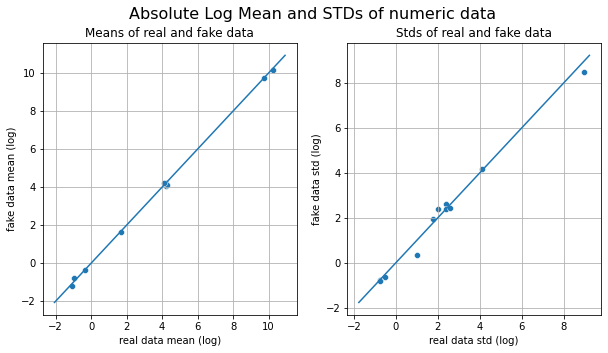

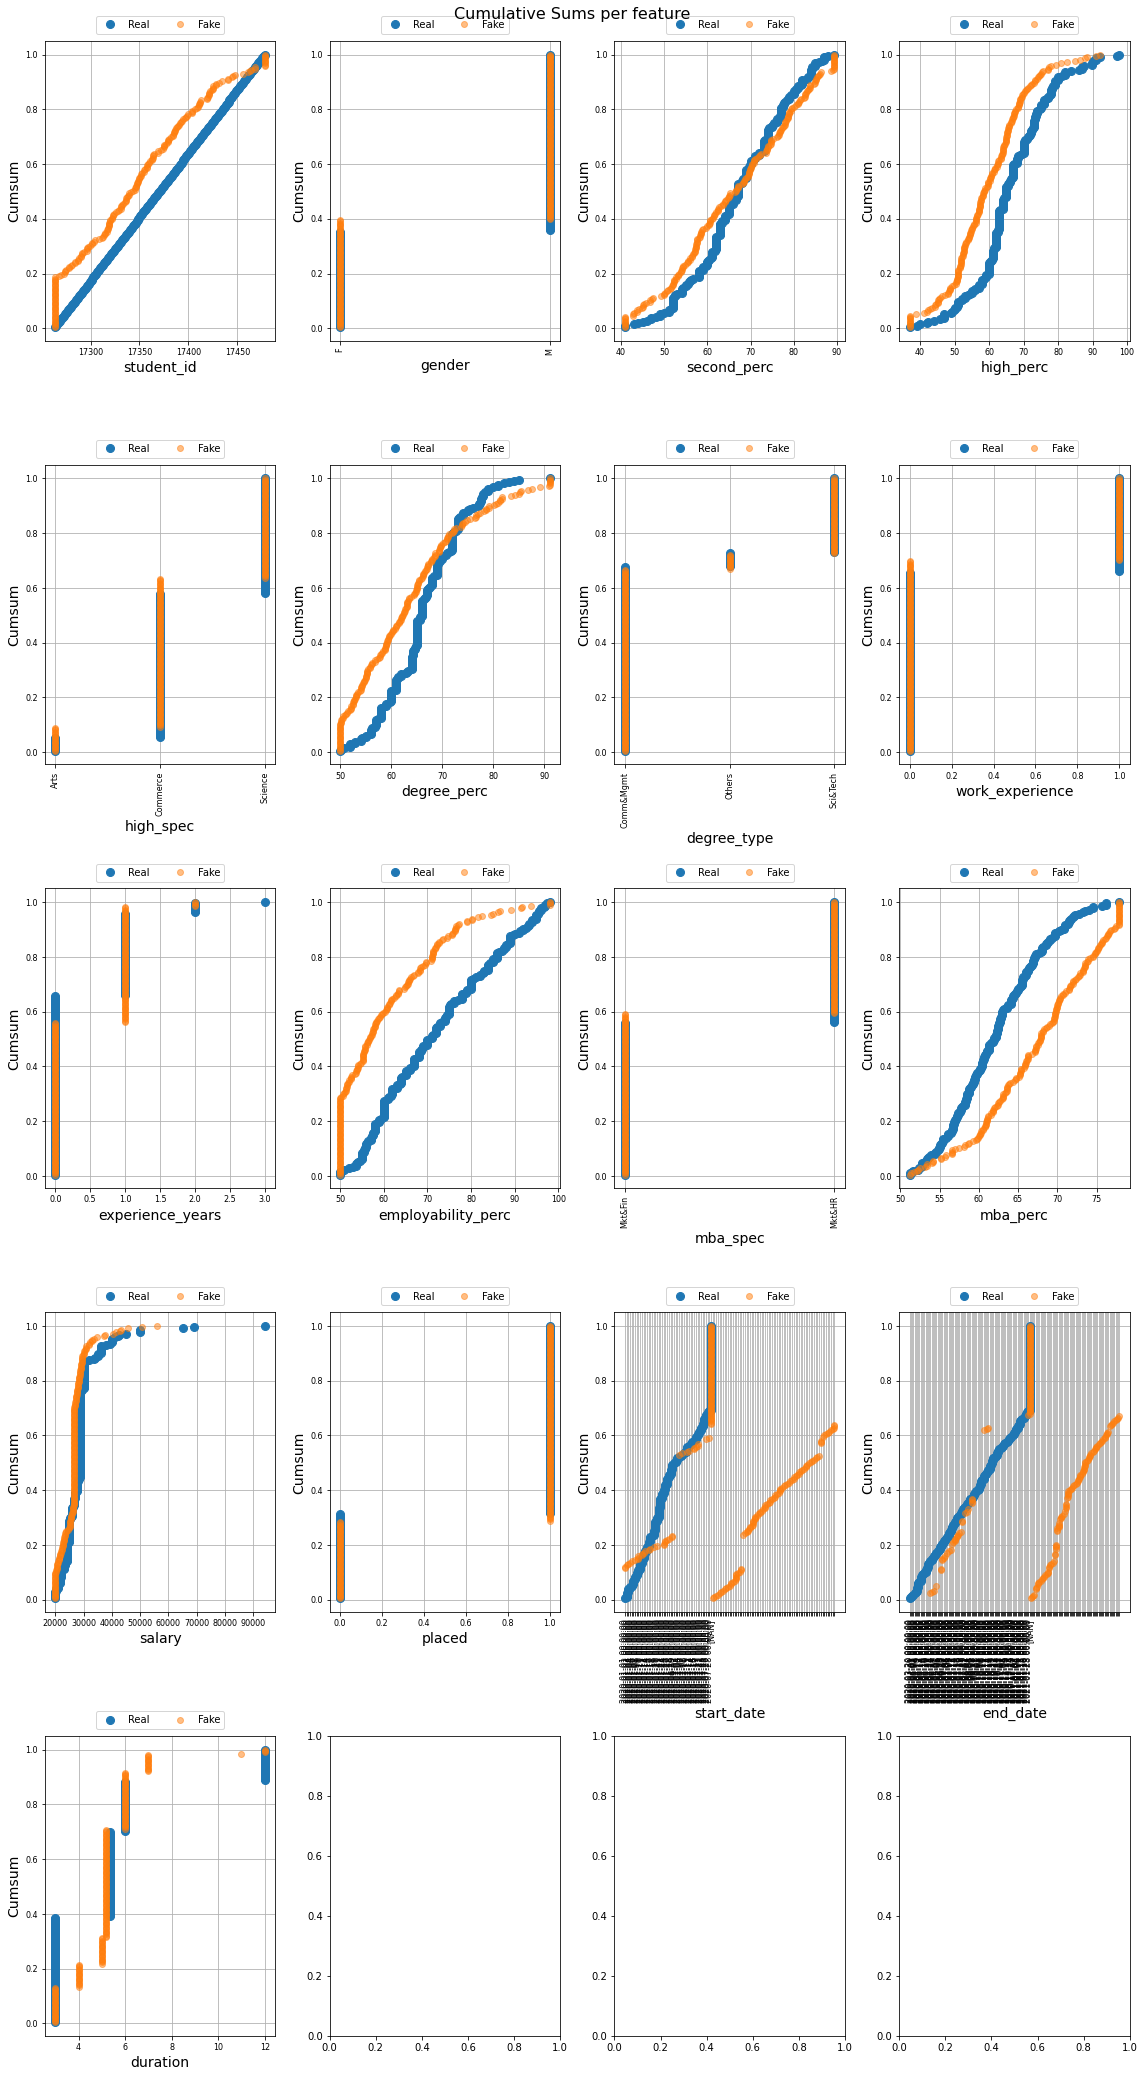

ValueError: ignored

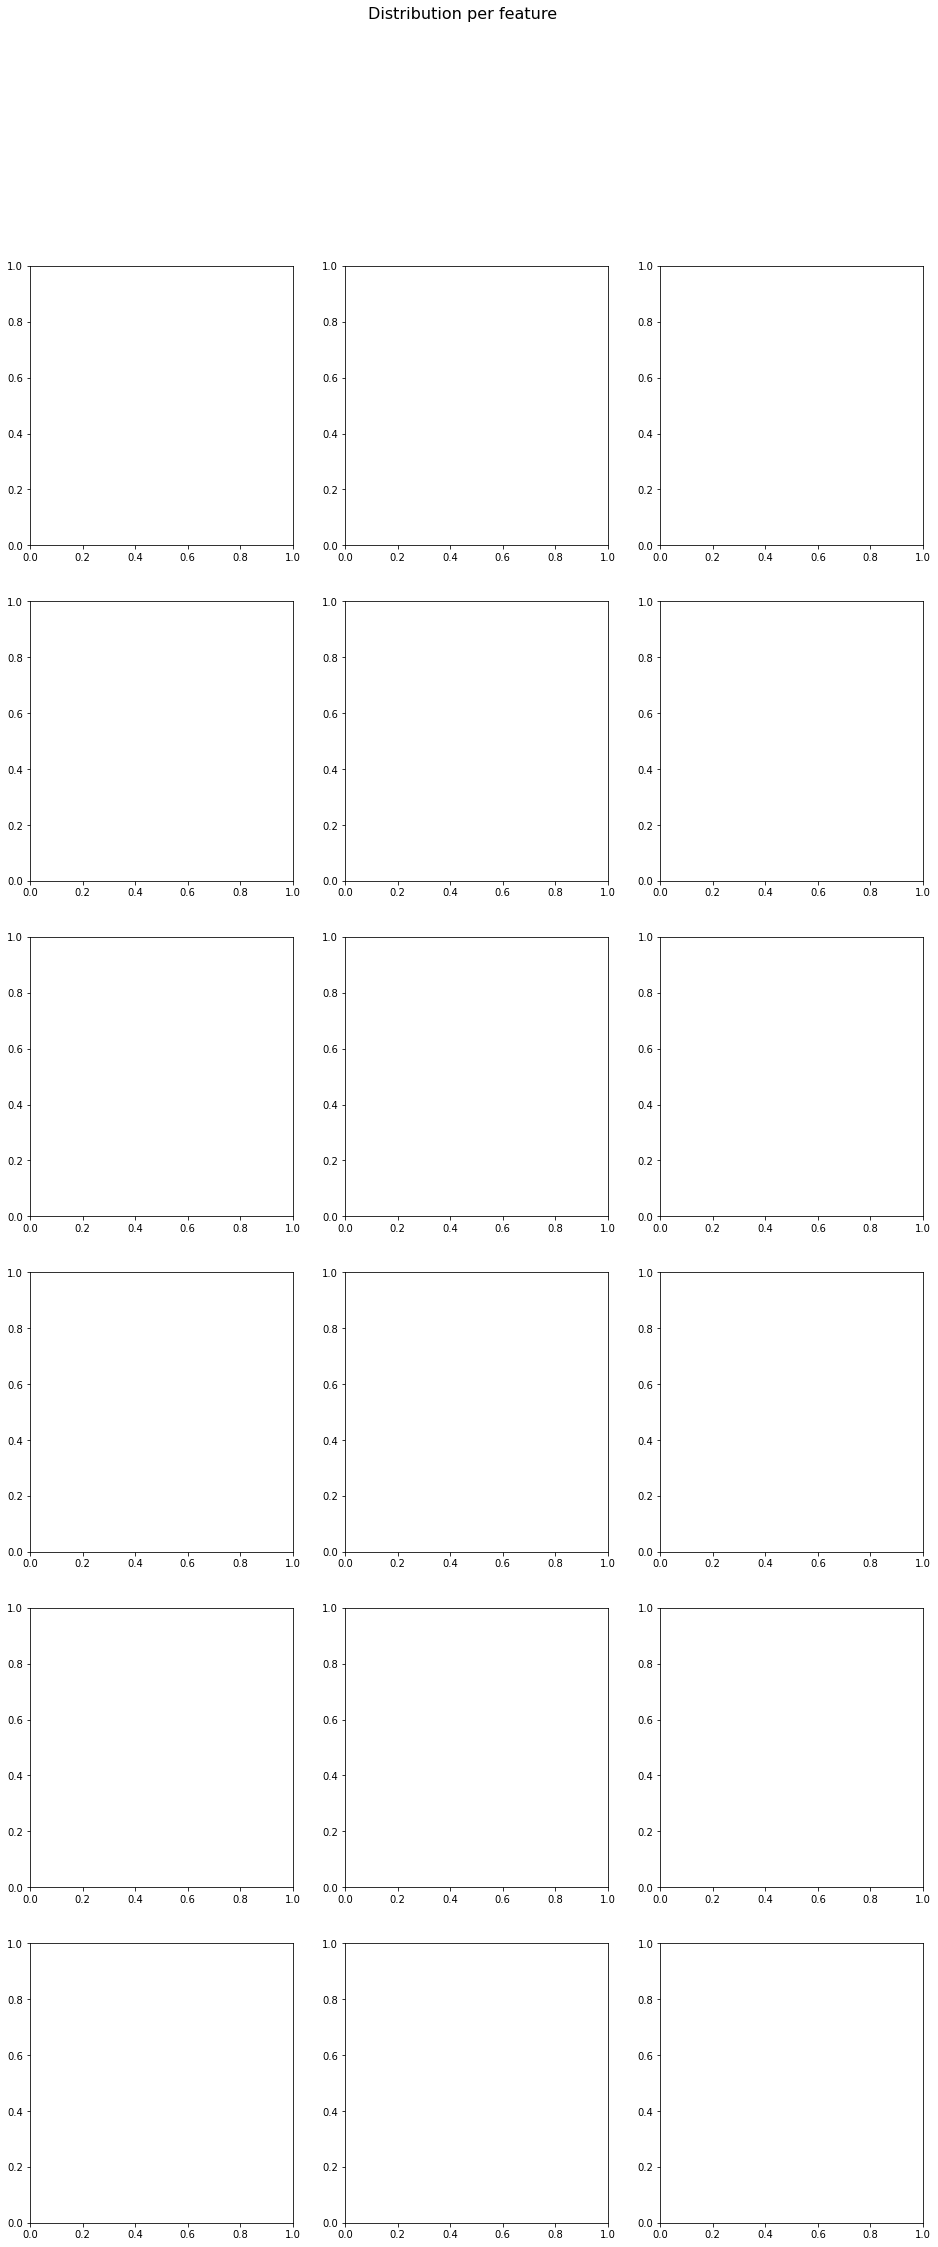

In [ ]:
import matplotlib.pyplot as plt
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(data,new_data)
table_evaluator.visual_evaluation()

In [ ]:
from sdv.tabular import CTGAN

model = CTGAN(
    verbose=True,
    cuda=True
    )

model.fit(data_real.sample(int(data_real.shape[0] * 0.5)))

Epoch 1, Loss G: -1.4824,Loss D:  0.0202
Epoch 2, Loss G: -3.7821,Loss D:  0.2188
Epoch 3, Loss G: -3.6473,Loss D:  0.6271
Epoch 4, Loss G: -2.3031,Loss D:  0.0916
Epoch 5, Loss G: -3.8299,Loss D:  0.2234
Epoch 6, Loss G: -6.9770,Loss D: -0.4105
Epoch 7, Loss G: -8.4439,Loss D: -0.4797
Epoch 8, Loss G: -6.8272,Loss D: -0.0021
Epoch 9, Loss G: -5.7508,Loss D: -0.5704
Epoch 10, Loss G: -7.6206,Loss D:  0.5408
Epoch 11, Loss G: -6.6477,Loss D: -0.5011
Epoch 12, Loss G: -6.6370,Loss D: -1.0944
Epoch 13, Loss G: -5.4779,Loss D: -0.1187
Epoch 14, Loss G: -6.8985,Loss D: -0.4162
Epoch 15, Loss G: -6.4794,Loss D: -0.5829
Epoch 16, Loss G: -6.5440,Loss D: -0.4293
Epoch 17, Loss G: -7.7394,Loss D:  0.1721
Epoch 18, Loss G: -8.0331,Loss D: -1.2982
Epoch 19, Loss G: -6.4789,Loss D: -0.9447
Epoch 20, Loss G: -7.6260,Loss D:  1.0381
Epoch 21, Loss G: -8.7801,Loss D:  1.0606
Epoch 22, Loss G: -9.3672,Loss D: -1.2585
Epoch 23, Loss G: -8.7874,Loss D:  1.4258
Epoch 24, Loss G: -6.4740,Loss D: -0.3474
E

In [ ]:
model.save("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/models/model_generated_data.pkl")

In [ ]:
new_data = model.sample(num_rows=20000)

In [ ]:
new_data

,column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,...,column_81,column_82,column_83,column_84,column_85,column_86,column_87,column_88,column_89,damage
0,1.0,11.0,5.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,2
1,3.0,23.0,6.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,1.0,0.0,1.0,1.0,-1.0,-1.0,-1.0,2
2,3.0,1.0,7.0,7.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,-1.0,1.0,1.0,-1.0,1.0,-1.0,-1.0,-1.0,1
3,2.0,1.0,7.0,6.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2
4,2.0,0.0,6.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,-1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,2.0,97.0,8.0,9.0,0.0,0.0,0.0,0.0,0.0,1.0,...,1.0,1.0,-1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2
19996,3.0,34.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2
19997,1.0,30.0,6.0,3.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2
19998,2.0,53.0,7.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,-0.0,1.0,1.0,1.0,1.0,-1.0,-1.0,-1.0,2


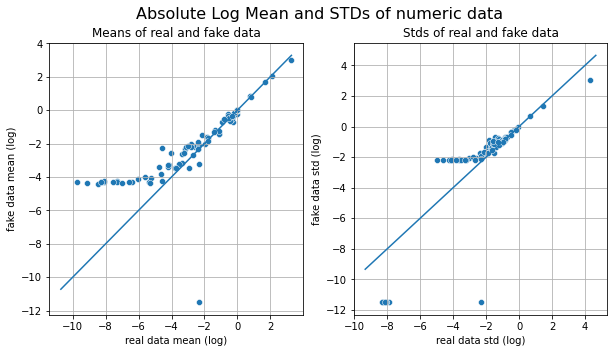

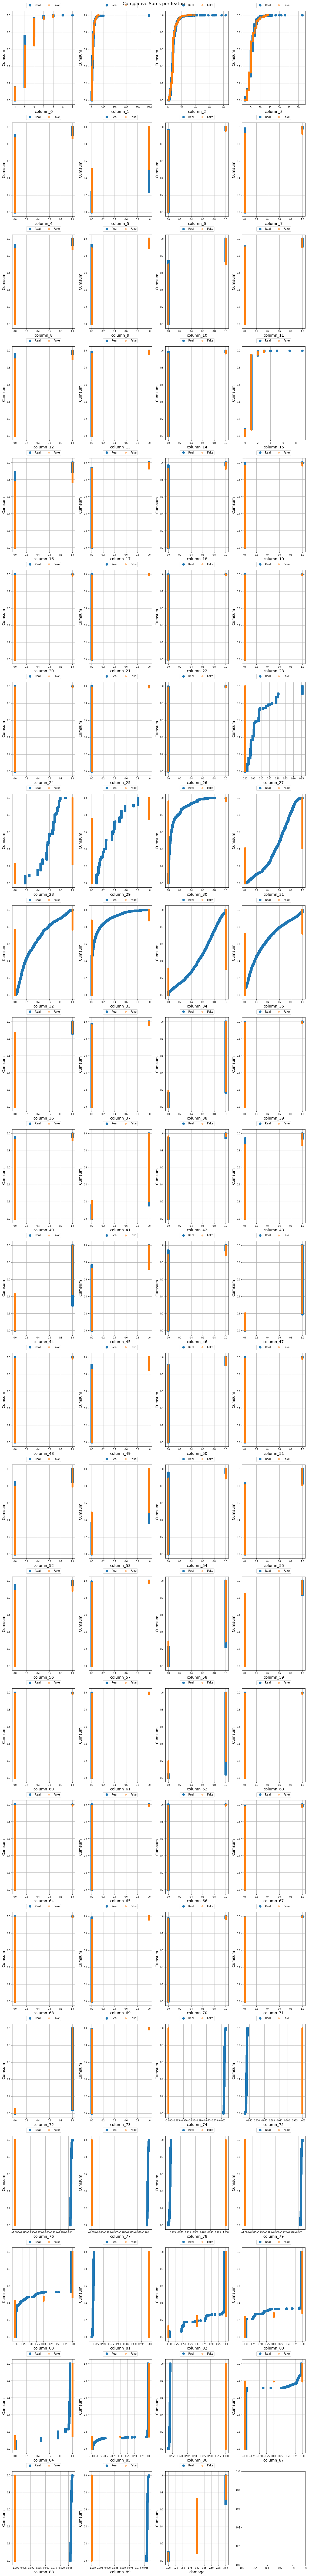

ValueError: ignored

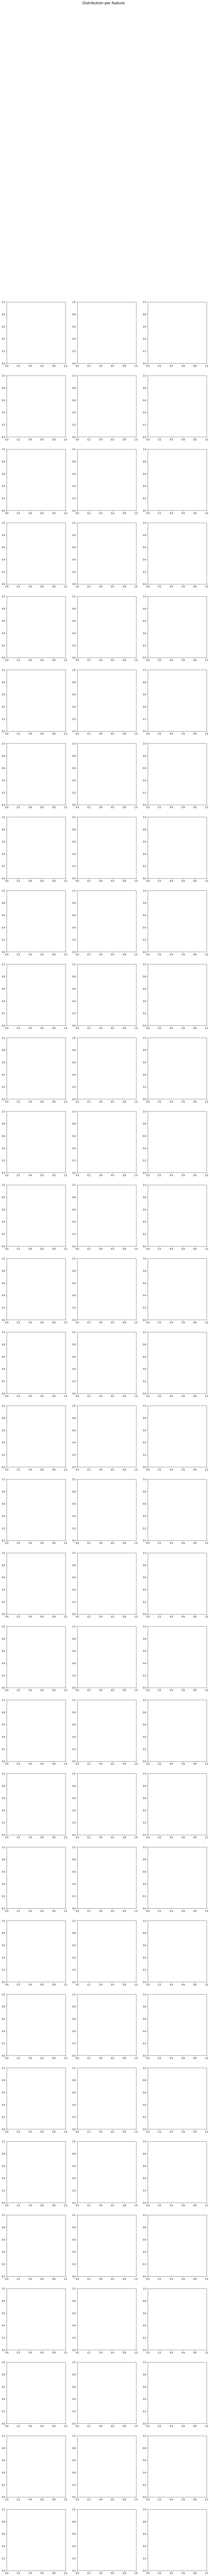

In [ ]:
import matplotlib.pyplot as plt
from table_evaluator import TableEvaluator

table_evaluator = TableEvaluator(data_real,new_data)
table_evaluator.visual_evaluation()

In [ ]:
array_new_data = new_data.iloc[:,:-1].to_numpy()
array_new_data_y = new_data.iloc[:,-1].to_numpy()

In [ ]:
fx_tr = np.concatenate((fx_tr, array_new_data), axis = 0)
fy_tr = np.concatenate((fy_tr, array_new_data_y), axis = 0)

In [ ]:
print(fx_tr.shape)
print(fy_tr.shape)

(280601, 90)
(280601,)


In [ ]:
#from sdv.sampling import Condition
#condition = Condition({'damage_grade': 1}, num_rows=5)
#data_generated = model.sample_conditions(conditions=[condition])

# Research hyperparameters

In [ ]:
#input best params here from randm.best_params_
modelrandonforest = RandomForestClassifier(random_state=42)

param_grid = { 
    'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8],
    'criterion' :['gini', 'entropy']
}

modelrandonforest = GridSearchCV(estimator=modelrandonforest, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelrandonforest.fit(X_train,y_train)

predsrandon=modelrandonforest.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsrandon,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 60 candidates, totalling 120 fits
[CV 1/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 1/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.729 total time=  14.8s
[CV 2/2; 1/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=200
[CV 2/2; 1/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=200;, score=0.728 total time=  14.8s
[CV 1/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 1/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.730 total time=  37.1s
[CV 2/2; 2/60] START criterion=gini, max_depth=4, max_features=auto, n_estimators=500
[CV 2/2; 2/60] END criterion=gini, max_depth=4, max_features=auto, n_estimators=500;, score=0.729 total time=  37.0s
[CV 1/2; 3/60] START criterion=gini, max_depth=4, max_features=sqrt, n_estimators=200
[CV 1/2; 3/60] END criterion=gini, max_d

In [ ]:
modelrandonforest.best_params_

{'criterion': 'gini',
 'max_depth': 8,
 'max_features': 'auto',
 'n_estimators': 500}

In [ ]:
#input best params here from randm.best_params_
modellgb = lgb.LGBMClassifier(random_seed=42, silent=True)

parameters = {
    'n_estimators': [100],
    'colsample_bytree': [0.7, 0.8],
    'max_depth': [15,20,25],
    'num_leaves': [50, 100, 200],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'min_split_gain': [0.3, 0.4],
    'subsample': [0.7, 0.8, 0.9],
    'subsample_freq': [20]
}
modellgb = GridSearchCV(estimator=modellgb, param_grid = parameters,cv = 2, scoring='f1_micro', verbose=10)
modellgb.fit(X_train,y_train)

predsllgb=modellgb.predict(X_test)


#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsllgb,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 972 candidates, totalling 1944 fits
[CV 1/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 1/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.760 total time=   3.3s
[CV 2/2; 1/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20
[CV 2/2; 1/972] END colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.7, subsample_freq=20;, score=0.761 total time=   3.3s
[CV 1/2; 2/972] START colsample_bytree=0.7, max_depth=15, min_split_gain=0.3, n_estimators=100, num_leaves=50, reg_alpha=1.1, reg_lambda=1.1, subsample=0.8, subsample_freq=20

In [ ]:
modellgb.best_params_

{'colsample_bytree': 0.8,
 'max_depth': 25,
 'min_split_gain': 0.3,
 'n_estimators': 100,
 'num_leaves': 50,
 'reg_alpha': 1.1,
 'reg_lambda': 1.2,
 'subsample': 0.9,
 'subsample_freq': 20}

In [ ]:
#input best params here from randm.best_params_
modelextratrees = ExtraTreesClassifier(random_state=42)

param_grid = {  
    "n_estimators": [360,500],
    "max_depth": [4,5,6,7,8,25,30,32] 
}

modelextratrees = GridSearchCV(estimator=modelextratrees, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelextratrees.fit(X_train,y_train)

predsextra=modelextratrees.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsextra,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 16 candidates, totalling 32 fits
[CV 1/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 1/2; 1/16] END max_depth=4, n_estimators=360;, score=0.720 total time=  24.6s
[CV 2/2; 1/16] START max_depth=4, n_estimators=360..............................
[CV 2/2; 1/16] END max_depth=4, n_estimators=360;, score=0.717 total time=  25.7s
[CV 1/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 1/2; 2/16] END max_depth=4, n_estimators=500;, score=0.719 total time=  34.2s
[CV 2/2; 2/16] START max_depth=4, n_estimators=500..............................
[CV 2/2; 2/16] END max_depth=4, n_estimators=500;, score=0.718 total time=  34.2s
[CV 1/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 1/2; 3/16] END max_depth=5, n_estimators=360;, score=0.728 total time=  29.0s
[CV 2/2; 3/16] START max_depth=5, n_estimators=360..............................
[CV 2/2; 3/16] END max_depth=5, n_estimator

In [ ]:
modelextratrees.best_params_

{'max_depth': 25, 'n_estimators': 360}

In [ ]:
modelgradient = GradientBoostingClassifier(random_state=42)

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "subsample":[0.5, 0.618,0.85],
    "n_estimators":[200,400]
    }

modelgradient = GridSearchCV(estimator=modelgradient, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelgradient.fit(X_train,y_train)

predsgradient=modelgradient.predict(X_test)

#f1 score is the metric used in the competition
accuracy1=f1_score(y_test,predsgradient,average='micro')
print("Score on test set")
print("\n ========================================================")
print(accuracy1)

Fitting 2 folds for each of 144 candidates, totalling 288 fits
[CV 1/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 1/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.731 total time=  39.6s
[CV 2/2; 1/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5
[CV 2/2; 1/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.5;, score=0.729 total time=  39.8s
[CV 1/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618
[CV 1/2; 2/144] END learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsample=0.618;, score=0.731 total time=  43.0s
[CV 2/2; 2/144] START learning_rate=0.01, loss=deviance, max_depth=3, max_features=log2, n_estimators=200, subsamp

In [ ]:
modelgradient.best_params_

{'learning_rate': 0.025,
 'loss': 'deviance',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 400,
 'subsample': 0.618}

In [ ]:
modelada = AdaBoostClassifier(random_state=42)

param_grid = {
    "algorithm":["SAMME","SAMME.R"],
    "learning_rate": [0.01, 0.025, 0.15, 0.2],
    "n_estimators":[200,400, 500, 1000]
    }

modelada = GridSearchCV(estimator=modelada, param_grid=param_grid, cv=2, scoring='f1_micro', verbose=10)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)

Fitting 2 folds for each of 32 candidates, totalling 64 fits
[CV 1/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 1/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 2/2; 1/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=200......
[CV 2/2; 1/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=200;, score=0.714 total time= 1.1min
[CV 1/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 1/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.712 total time= 2.2min
[CV 2/2; 2/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=400......
[CV 2/2; 2/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=400;, score=0.713 total time= 2.2min
[CV 1/2; 3/32] START algorithm=SAMME, learning_rate=0.01, n_estimators=500......
[CV 1/2; 3/32] END algorithm=SAMME, learning_rate=0.01, n_estimators=500;, score=0.713 total time= 2.8min
[CV 

In [ ]:
modelada.best_params_

{'algorithm': 'SAMME.R', 'learning_rate': 0.15, 'n_estimators': 500}

# Applying machine learning

In [ ]:
#fitting
rf = RandomForestClassifier(random_state=42,criterion='entropy', max_depth=8, max_features='auto', n_estimators=200)
rf.fit(fx_tr,fy_tr)

#pred
predrf=rf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_random=f1_score(fy_tr,predrf,average='micro')
print("F1 score from Random Forest: ",f1_random)
#F1 score from Random Forest:  0.7515281982801294

F1 score from Random Forest:  0.7463408897331085


In [ ]:
#fitting
modellgb_1 = lgb.LGBMClassifier(colsample_bytree=0.7, max_depth=25, min_split_gain=0.3,
               num_leaves=200, random_seed=42, reg_alpha=1.3, reg_lambda=1.1,
               subsample=0.9, subsample_freq=20)
modellgb_1.fit(fx_tr,fy_tr)

#pred
predslgb = modellgb_1.predict(fx_tr)

#f1 score is the metric used in the competition
f1_lgb=f1_score(fy_tr,predslgb,average='micro')
print("F1 score from LGBM: ",f1_lgb)
#F1 score from LGBM:  0.7892793964720013

F1 score from LGBM:  0.7835752545429274


In [ ]:
#fitting
modelextratrees = ExtraTreesClassifier(random_state=42, max_depth = 25, n_estimators = 500)
modelextratrees.fit(fx_tr,fy_tr)

#pred
predsextra=modelextratrees.predict(fx_tr)

#f1 score is the metric used in the competition
f1_extra = f1_score(fy_tr,predsextra,average='micro')
print("F1 score from Extratrees: ",f1_extra)
#F1 score from Extratrees:  0.8935882824701363

F1 score from Extratrees:  0.8876946268901394


In [ ]:
#fitting
modelxgb_cl = xgb.XGBClassifier(random_state=42,objective='multi:softmax', gamma=0.001369048068388758, eta=0.11,
                  max_depth= 20,
                  min_child_weight=9,
                  num_class= 4,
                  subsample= .85,
                  colsample_bytree= .9, verbose=10)
modelxgb_cl.fit(fx_tr,fy_tr)

#pred
predsxgb_cl = modelxgb_cl.predict(fx_tr)

#f1 score is the metric used in the competition
f1_xgb=f1_score(fy_tr,predsxgb_cl,average='micro')
print("F1 score from XGB: ",f1_xgb)
#F1 score from XGB:  0.8720956558109908

F1 score from XGB:  0.8797438355529738


In [ ]:
#fitting
modelgradient = GradientBoostingClassifier(random_state=42, learning_rate=0.15,loss='deviance', max_depth=8, max_features='sqrt',n_estimators= 400,subsample=0.85)
modelgradient.fit(fx_tr,fy_tr)

#pred
predsgradient = modelgradient.predict(fx_tr)

#f1 score is the metric used in the competition
f1_gradient=f1_score(fy_tr,predsgradient,average='micro')
print("F1 score from Gradient Boosting: ",f1_gradient)
#F1 score from Gradient Boosting:  0.8358294864563068

F1 score from Gradient Boosting:  0.8333612496035296


In [ ]:
#fitting
modelcat = CatBoostClassifier(eval_metric='TotalF1',random_seed=42, silent=True, border_count=13, depth= 10, iterations = 5000, l2_leaf_reg = 3, learning_rate = 0.05)
modelcat.fit(fx_tr,fy_tr)

#pred
predscat=modelcat.predict(fx_tr)

#f1 score is the metric used in the competition
f1_cat=f1_score(fy_tr,predscat,average='micro')
print("F1 score from Cat Boost: ",f1_cat)
#F1 score from Cat Boost:  0.8917962709275866

F1 score from Cat Boost:  0.8908628265758141


In [ ]:
#fitting
modelada = AdaBoostClassifier(random_state=42,base_estimator=None, learning_rate=0.4, n_estimators=190)
modelada.fit(fx_tr,fy_tr)

#pred
predsada=modelada.predict(fx_tr)

#f1 score is the metric used in the competition
f1_ada=f1_score(fy_tr,predsada,average='micro')
print("F1 score from Ada Boost: ",f1_ada)
#F1 score from Ada Boost:  0.7521997229481084

F1 score from Ada Boost:  0.7352646640603562


In [ ]:
from imbalanced_ensemble.ensemble import AsymBoostClassifier

#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(X_train,y_train,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(X_test)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(y_test,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)
#F1 score from AsymBoost:  0.7367855566854051

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.716     ┃
┃      5      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.722     ┃
┃     10      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.730     ┃
┃     15      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.734     ┃
┃     20      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.740     ┃
┃     25      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.742     ┃
┃     30      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.743     ┃
┃     35      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.741     ┃
┃     40      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.739     ┃
┃     45      ┃ {1: 19954, 2: 118772, 3: 69754} ┃   0.739     ┃
┃     50      ┃ {1: 19954, 2: 118772, 3:

In [ ]:
#fitting
AsymBoost = AsymBoostClassifier(random_state=42)
AsymBoost.fit(fx_tr,fy_tr,train_verbose=True,eval_metrics={'micro_f1': (f1_score, {'average': 'micro'})})

#pred
predAsymBoost=AsymBoost.predict(fx_tr)

#f1 score is the metric used in the competition
f1_AsymBoost=f1_score(fy_tr,predAsymBoost,average='micro')
print("F1 score from AsymBoost: ",f1_AsymBoost)

┏━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━┓
┃             ┃                                 ┃ Data: train ┃
┃ #Estimators ┃       Class Distribution        ┃   Metric    ┃
┃             ┃                                 ┃  micro_f1   ┃
┣━━━━━━━━━━━━━╋━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╋━━━━━━━━━━━━━┫
┃      1      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.709     ┃
┃      5      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.713     ┃
┃     10      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.721     ┃
┃     15      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.728     ┃
┃     20      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.729     ┃
┃     25      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.727     ┃
┃     30      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.729     ┃
┃     35      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.728     ┃
┃     40      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.726     ┃
┃     45      ┃ {1: 26943, 2: 160944, 3: 92714} ┃   0.725     ┃
┃     50      ┃ {1: 26943, 2: 160944, 3:

# Ensemble Classifier - Voting Classifier

In [ ]:
%%time

voting_clf = VotingClassifier(estimators=[('rf', rf),
                                          ('lgb',modellgb_1),
                                          ('gradient',modelgradient),
                                          ('extra',modelextratrees),
                                          ('xbg', modelxgb_cl),
                                          ('cat', modelcat),
                                          ('ada', modelada),
                                          ('AB', AsymBoost)], voting='soft', verbose=10)
voting_clf.fit(fx_tr,fy_tr)

#pred
pred_votting = voting_clf.predict(fx_tr)

#f1 score is the metric used in the competition
f1_votting = f1_score(fy_tr,pred_votting,average='micro')

print("F1 score from Votting: ",f1_votting) #0.7501 | Baseline = 0.7504
#F1 score from Votting:  0.8553075391115154

[Voting] ....................... (1 of 8) Processing rf, total= 1.1min
[Voting] ...................... (2 of 8) Processing lgb, total=  37.3s
[Voting] ................. (3 of 8) Processing gradient, total=11.0min
[Voting] .................... (4 of 8) Processing extra, total= 5.9min
[Voting] ...................... (5 of 8) Processing xbg, total=23.6min
[Voting] ...................... (6 of 8) Processing cat, total=17.7min
[Voting] ...................... (7 of 8) Processing ada, total= 2.2min
[Voting] ....................... (8 of 8) Processing AB, total=  39.4s
F1 score from Votting:  0.8543269624840967
CPU times: user 2h 39min 11s, sys: 50.8 s, total: 2h 40min 2s
Wall time: 1h 4min 57s


# Evaluations

In [ ]:
probas = [c.predict_proba(fx_tr) for c in (rf, modellgb, modelgradient, modelextratrees, modelxgb_cl, voting_clf)]

In [ ]:
class1_1 = [pr[0, 0] for pr in probas]
class2_1 = [pr[0, 1] for pr in probas]
class3_1 = [pr[0, 2] for pr in probas]

In [ ]:
df_models = pd.DataFrame(None,columns=["percent","classe"])

for n in class1_1:
  df_class1 = pd.DataFrame([[n, 'class1']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class1])

for n in class2_1:
  df_class2 = pd.DataFrame([[n, 'class2']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class2])

for n in class3_1:
  df_class3 = pd.DataFrame([[n, 'class3']], columns=["percent","classe"])
  df_models = pd.concat([df_models, df_class3])

df_models["models"] = ['Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier',
                      'Random Forest', 'LGBM', 'Gradient Boosting', 'Extraa Trees', 'XGB Boosting', 'Votting Classifier']

df_models['percent'] = round(df_models.percent,2)

In [ ]:
df_models

,percent,classe,models
0,0.01,class1,Random Forest
0,0.00,class1,LGBM
0,0.00,class1,Gradient Boosting
0,0.00,class1,Extraa Trees
0,0.00,class1,XGB Boosting
0,0.04,class1,Votting Classifier
0,0.24,class2,Random Forest
0,0.12,class2,LGBM
0,0.15,class2,Gradient Boosting
0,0.14,class2,Extraa Trees


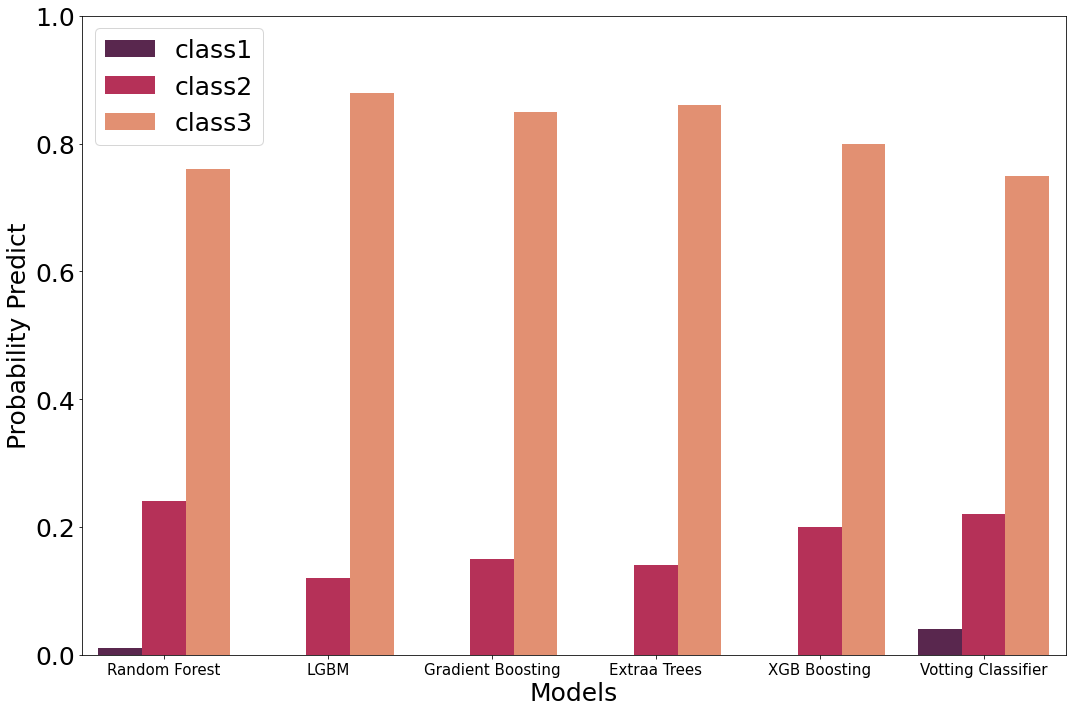

In [ ]:
fig, ax = plt.subplots(figsize=(15,10))

sns.color_palette("rocket", as_cmap=True)

sns.barplot(data=df_models, x='models', y='percent', hue='classe', palette='rocket')

plt.ylim([0, 1])
plt.legend(prop={'size': 25})
plt.ylabel('Probability Predict', size=25)
plt.xlabel('Models', size=25)
plt.xticks(fontsize=15)
plt.yticks(fontsize=25)
plt.tight_layout()
plt.show()

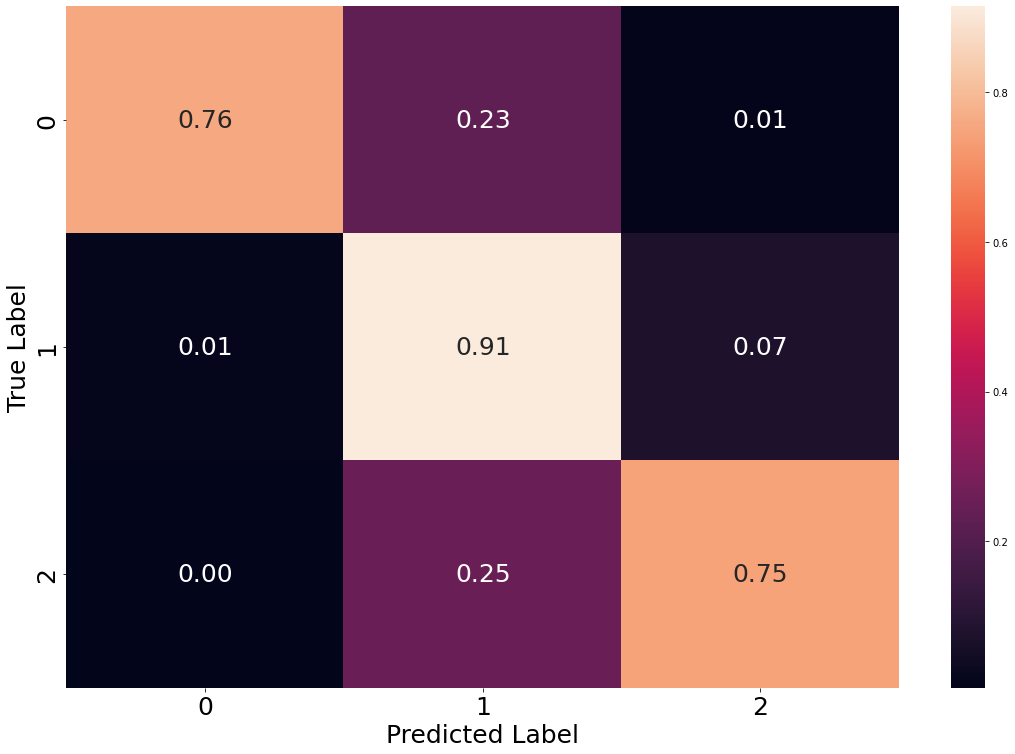

In [ ]:
cm = confusion_matrix(fy_tr, pred_votting, labels=voting_clf.classes_)
cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(cmn, annot=True, fmt='.2f', annot_kws={'size': 25}, ax=ax)
fig.tight_layout()
plt.ylabel('True Label', size=25)
plt.xlabel('Predicted Label', size=25)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show(block=False)

# Submit

In [ ]:
pred_votting_base_test = voting_clf.predict(fx_te)

sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/generated_data_1.csv", index=False)

In [ ]:
sub_csv = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/submission_format.csv")

sub_csv["damage_grade"] = pred_votting_base_test
sub_csv.to_csv("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/output/submit/ensemble_1.csv", index=False)

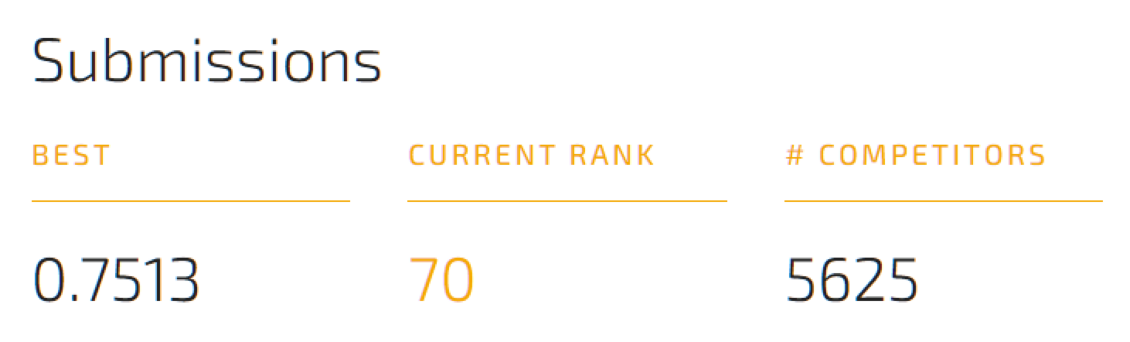

In [ ]:
img = cv2.imread("/content/drive/My Drive/Colab Notebooks/Richter's Predictor: Modeling Earthquake Damage/data/Results 2022-08-08.png")

plt.figure(figsize=(20, 16))
plt.imshow(img)
plt.axis('off')
plt.show()